# A Multiclass Support Vector Machine for Image Classification

We use the [`CIFAR-10` data set ](https://www.cs.toronto.edu/~kriz/cifar.html) and show an implementation of the support vector machine algorithm for image classification. 

+ `CIFAR-10` has 10 labels
+ 50 000 tiny training images (color images, 32 X 32 X 3 pixels each)
+ 10 000 test images

What follows is part of a solution to assignment 1 from the [CS 231 course](http://cs231n.stanford.edu/syllabus.html).

+ The assignment instructions are found [here](http://cs231n.github.io/assignments2016/assignment1/) 
+ The files needed to complete the entire assignment ( a zip file ) [can be downloaded from here](http://vision.stanford.edu/teaching/cs231n/winter1516_assignment1.zip) 
+ To reproduce the results found in this notebook, first download and unzip the assignment files. A directory called `assignment1` will be created after the files have been unzipped. Then download this notebook and save it in the `assignment1` directory
+ Make sure to download the `CIFAR-10` data as well. This can be done by simply running the `./get_datasets.sh` script from the `assignment1/cs231n/datasets` directory ( these instructions are also found on the [assignment instructions page](http://cs231n.github.io/assignments2016/assignment1/) )
+ Now simply run the code in this notebook as usual

The lecture [notes on linear classification can be found here](http://cs231n.github.io/linear-classify/). These notes are a prerequisite for understanding this notebook.

### This notebook shows how to:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check the implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD** (stochastic gradient descent)
- **visualize** the final learned weights


## Load, View and Preprocess the `CIFAR-10` Data

### Preprocessing, part 1 of 2

Here we just load the data and look at a few images in each of the 10 classes. Each column in the picture below represents a class. Images within the columns are examples from the classs represented by the columns.

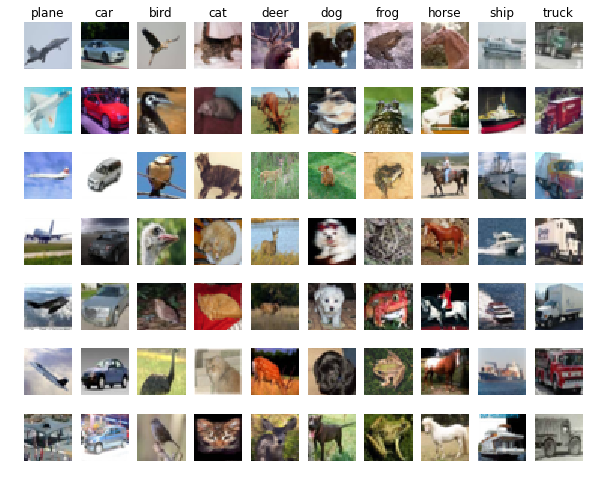

In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Preprocessing, part 2 of 2

Here we prepare data for machine learning. We do two things: 

1. We split the data into train, validation and test sets 

2. We perform normalization of our input features (i.e. we normalize the images. We sometimes refer to each pixel of an image as a feature, following the machine learning terminology)

For part 2, we center the data by subtracting the mean from every feature. This means that we _first_ compute the mean of every feature in the training set. This vector of means, which is 3072 long since we have that many features, can be reshaped into an image and refered to as the _mean image_  (what the mean image looks like is shown below). We _next_ subtract the mean image from every training image. As a result, our training data now consists of images whose pixel intensities range from about -127 to about +127. We then scale each input feature so that its values range from -1 to +1. The reason for doing this will become apparent when we understand the dynamics of the gradient descent algorithm. 

In [2]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

#print 'Train data shape: ', X_train.shape
#print 'Train labels shape: ', y_train.shape
#print 'Validation data shape: ', X_val.shape
#print 'Validation labels shape: ', y_val.shape
#print 'Test data shape: ', X_test.shape
#print 'Test labels shape: ', y_test.shape

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


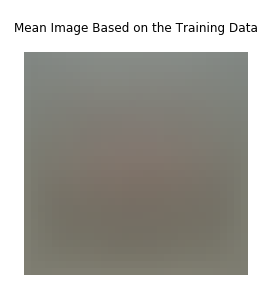

In [3]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
#print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.title('\nMean Image Based on the Training Data\n'); plt.axis('off')
plt.show()

In [4]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

Here we also append the bias vector of ones to the weight matrix (the usual bias trick) so that we optimize a single matrix of weights $W$. 

In [5]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Clasifier

We now write the multiclass support vector machine clasifyer (`SVM`). 

The final result is found here: [`./cs231n/classifiers/linear_svm.py`](./cs231n/classifiers/linear_svm.py).

> `./cs231n/classifiers/` is the relative path from the `assignment1` directory ( which is where all the downloaded assignment files were unzipped ) to the directory that contains files that implement classifiers. `linear_svm.py` is one of these classifiers that we modified to produce the results that follow.

### Implementing the Loss Function

We find the optimal set of $w$s by minimizing the hinge loss finction ( see the _Loss Function_ section of the [linear classification notes ](http://cs231n.github.io/linear-classify/) for details ). 

The *Loss Function* section of the [linear classification notes ](http://cs231n.github.io/linear-classify/) explains both the naive and the vectorized implementations of the hinge loss function.

The main work done here is the computation of gradients. 


In [6]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.542640


**So here we explain how gradient is implemented**

In [7]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.162095 analytic: 4.162095, relative error: 7.498758e-11
numerical: -1.116733 analytic: -1.116733, relative error: 1.571625e-11
numerical: -3.393818 analytic: -3.393818, relative error: 4.405865e-11
numerical: 0.029702 analytic: 0.029702, relative error: 1.028873e-08
numerical: 13.625037 analytic: 13.625037, relative error: 2.638297e-11
numerical: -10.777723 analytic: -10.777723, relative error: 7.731340e-12
numerical: -2.170647 analytic: -2.170647, relative error: 5.000898e-11
numerical: -21.954216 analytic: -21.954216, relative error: 1.533936e-11
numerical: -24.580666 analytic: -24.580666, relative error: 3.852523e-13
numerical: 11.443327 analytic: 11.443327, relative error: 8.302520e-12
numerical: -3.699529 analytic: -3.699529, relative error: 7.532268e-11
numerical: -61.590978 analytic: -61.590978, relative error: 7.299070e-12
numerical: 1.876679 analytic: 1.876679, relative error: 2.679120e-10
numerical: 2.859981 analytic: 2.859981, relative error: 1.116803e-10
numeri

So here we see that the implementation is correct!

In [10]:
grad.shape

(3073, 10)

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.542640e+00 computed in 0.123836s
Vectorized loss: 9.542640e+00 computed in 0.127471s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.122769s
Vectorized loss and gradient: computed in 0.118959s
difference: 0.000000
